Implementation of Variational Auto Encoder (VAE) 
-------------------------------------------------------------------------
Based on http://kvfrans.com/variational-autoencoders-explained/ and https://arxiv.org/abs/1606.05908 using binary MNIST.

Mirror: https://gist.github.com/Meehai/e2557f040712f904408b61790c681de0 until GitLab fixes their Notebooks renderer.

Notes: loss is used using the empirical MB \* 28 \* 28 \* reconstruction_loss + latent_loss

If you get NaNs during training, lower the learning rate or change the optimizer.

But first, some imports.

In [1]:
%matplotlib inline
import sys
import numpy as np
from neural_wrappers.readers import MNISTReader
from neural_wrappers.pytorch import NeuralNetworkPyTorch, maybeCuda, maybeCpu
from neural_wrappers.callbacks import SaveModels, Callback
import matplotlib.pyplot as plt
from scipy.misc import toimage
from PIL import Image

import torch as tr
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F


/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


First, we're going to take the regular MNIST reader and override the iterate_once method to generate binary data.

In [2]:
datasetPath = "/home/mihai/Public/Datasets/mnist/mnist.h5"


class BinaryMNISTReader(MNISTReader):
    def iterate_once(self, type, miniBatchSize):
        for items in super().iterate_once(type, miniBatchSize):
            images, _ = items
            # Images are N(0, I), so we can threshold at 0 to get binary values.
            images = np.float32(images > 0)
            yield images, images

Next, let's define the Encoder and Decoder models, using only Fully Connected layers, as this is enough for MNIST.

The output of the Encoder is a pair of two vectors, one mean and one std vector, which is going to be optimized by the training process in order to be a normal gaussian: N(0, I). The Decoder takes some generated samples, by some Gaussian process and generate some data.

The idea is that using a double crossed loss, one to maximize reconstruction of the dataset, and one to force the encoder to generate a normal gaussian, we can then sample from an actual normal gaussian and generate data similar to our initial dataset.

In [3]:
class Encoder(NeuralNetworkPyTorch):
    def __init__(self, numEncodings):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 100)
        self.mean_fc = nn.Linear(100, numEncodings)
        self.mean_std = nn.Linear(100, numEncodings)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        y1 = F.relu(self.fc1(x))
        y2 = F.relu(self.fc2(y1))
        y_mean = self.mean_fc(y2)
        y_std = self.mean_std(y2)
        return y_mean, y_std
    
class Decoder(NeuralNetworkPyTorch):
    def __init__(self, numEncodings):
        super().__init__()
        self.fc1 = nn.Linear(numEncodings, 300)
        self.fc2 = nn.Linear(300, 28 * 28)

    def forward(self, z_samples):
        y1 = F.relu(self.fc1(z_samples))
        y2 = self.fc2(y1)
        y_decoder = F.sigmoid(y2)
        return y_decoder

In [4]:
class VAE(NeuralNetworkPyTorch):
    def __init__(self, numEncodings, encoderType="FCEncoder"):
        super().__init__()
        self.numEncodings = numEncodings
        self.encoder = Encoder(numEncodings)
        self.decoder = Decoder(numEncodings)

    def forward(self, x):
        batchSize = x.shape[0]
        y_mean, y_std = self.encoder(x)
        # "Reparametrization trick": Sample from N(0, I) and multiply by our distribution's mean/std.
        z_samples = Variable(maybeCuda(tr.randn(batchSize, self.numEncodings)), requires_grad=False)
        z_samples *= y_std
        z_samples += y_mean
        y_decoder = self.decoder(z_samples)
        y_decoder = y_decoder.view(batchSize, 28, 28)
        return y_decoder, y_mean, y_std

Next, let's define the loss function, which, as said before is twicefold. In order to optimize a random Gaussian to be N(0, I) we use the KL-Divergence (relative entropy), which is differentiable and thus can be minimized.

In [5]:
def lossFunction(y_network, y_target):
    y_decoder, y_mean, y_std = y_network
    # KL-Divergence between two Gaussians, one with y_mean, y_std and other is N(0, I)
    latent_loss = 0.5 * tr.sum((y_std**2 + y_mean**2 - 1 - tr.log(y_std**2)))
    decoder_loss = F.binary_cross_entropy(y_decoder, y_target)
    return latent_loss + 76800 * decoder_loss

# Define each loss independently as well, so we can use these values as metrics during training
def lossLatent(y_network, y_target, **kwargs):
    y_decoder, y_mean, y_std = y_network
    latent_loss = 0.5 * np.sum((y_std**2 + y_mean**2 - 1 - np.log(y_std**2)))
    return latent_loss

def lossDecoder(y_network, y_target, **kwargs):
    y_decoder, y_mean, y_std = y_network
    decoder_loss = (F.binary_cross_entropy(Variable(tr.from_numpy(y_decoder).cpu()), \
        Variable(tr.from_numpy(y_target)).cpu())).data.numpy()
    return 76800 * decoder_loss

Now, let's define the model, the optimizer and criterion, and start training.

In [6]:
reader = BinaryMNISTReader(datasetPath)
generator = reader.iterate("train", miniBatchSize=100)
numIterations = reader.getNumIterations("train", miniBatchSize=100)

network = maybeCuda(VAE(numEncodings=300))
network.setCriterion(lossFunction)
network.setOptimizer(optim.SGD, lr=0.000001, momentum=0.3)
metrics = { "Latent Loss" : lossLatent, "Decoder Loss" : lossDecoder }
network.setMetrics(metrics)
print(network.summary())


[MNIST Reader] Setup complete
[Model summary]
General neural network architecture. Update __str__ in your model for more details when using summary.
Parameters count: 475484. Trainable parameters: 475484.
Metrics: 'Latent Loss', 'Decoder Loss', 'Loss'
Optimizer: SGD. Learning rate: 1e-06, Momentum: 0.3, Dampening: 0, Weight Decay: 0, Nesterov: False



Let's define a callback, that during training, every 10 epochs, will sample 10 images and plot them, so we can have some reference to how well the model performed.

In [7]:
def plot_images(images, title):
    fig = plt.figure()
    numImages = len(images)

    fig.add_subplot(1, numImages, 1)
    plt.imshow(np.array(Image.fromarray(images[0])), cmap="gray")
    plt.axis("off")
    plt.title(title)
    for j in range(1, numImages):
        fig.add_subplot(1, numImages, j + 1)
        plt.imshow(np.array(Image.fromarray(images[j])), cmap="gray")
        plt.axis("off")
    plt.show()
    
class PlotCallback(Callback):
    def onEpochEnd(self, **kwargs):
        epoch = kwargs["epoch"]
        if epoch % 10 != 1:
            return
        model = kwargs["model"]
        z_samples = Variable(maybeCuda(tr.randn(10, model.numEncodings)))
        y_result = model.decoder.forward(z_samples)
        result = maybeCpu(y_result.data).numpy().reshape((-1, 28, 28))
        result_binary = np.uint8(result > 0.5)
        title = "Epoch %d" % (epoch)
        plot_images(result_binary, title)

Training for 100 epochs...
Epoch 1/100. Done: 1.00%. Latent Loss: 797182.43. Decoder Loss: 40430.45. Loss: 837613.00. Took: 0:00:35.447125.
Epoch 1. Improvement from nan to 837613.00


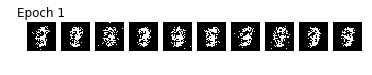

Epoch 2/100. Done: 2.00%. Latent Loss: 18136.78. Decoder Loss: 26454.17. Loss: 44590.93. Took: 0:00:22.377619.
Epoch 2. Improvement from 837613.00 to 44590.93
Epoch 3/100. Done: 3.00%. Latent Loss: 10718.98. Decoder Loss: 23654.25. Loss: 34373.23. Took: 0:00:23.554513.
Epoch 3. Improvement from 44590.93 to 34373.23
Epoch 4/100. Done: 4.00%. Latent Loss: 7245.10. Decoder Loss: 23134.72. Loss: 30379.85. Took: 0:00:23.336416.
Epoch 4. Improvement from 34373.23 to 30379.85
Epoch 5/100. Done: 5.00%. Latent Loss: 5218.22. Decoder Loss: 22975.51. Loss: 28193.74. Took: 0:00:25.485976.
Epoch 5. Improvement from 30379.85 to 28193.74
Epoch 6/100. Done: 6.00%. Latent Loss: 3920.76. Decoder Loss: 22930.83. Loss: 26851.60. Took: 0:00:23.355890.
Epoch 6. Improvement from 28193.74 to 26851.60
Epoch 7/100. Done: 7.00%. Latent Loss: 3041.47. Decoder Loss: 22916.01. Loss: 25957.49. Took: 0:00:17.305303.
Epoch 7. Improvement from 26851.60 to 25957.49
Epoch 8/100. Done: 8.00%. Latent Loss: 2422.32. Decoder

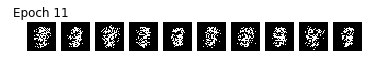

Epoch 12/100. Done: 12.00%. Latent Loss: 1203.62. Decoder Loss: 22942.67. Loss: 24146.30. Took: 0:00:16.953376.
Epoch 12. Improvement from 24329.49 to 24146.30
Epoch 13/100. Done: 13.00%. Latent Loss: 1055.70. Decoder Loss: 22943.90. Loss: 23999.60. Took: 0:00:31.846047.
Epoch 13. Improvement from 24146.30 to 23999.60
Epoch 14/100. Done: 14.00%. Latent Loss: 939.36. Decoder Loss: 22949.62. Loss: 23888.98. Took: 0:00:18.605239.
Epoch 14. Improvement from 23999.60 to 23888.98
Epoch 15/100. Done: 15.00%. Latent Loss: 848.21. Decoder Loss: 22951.46. Loss: 23799.67. Took: 0:00:14.860086.
Epoch 15. Improvement from 23888.98 to 23799.67
Epoch 16/100. Done: 16.00%. Latent Loss: 774.77. Decoder Loss: 22949.48. Loss: 23724.25. Took: 0:00:15.073771.
Epoch 16. Improvement from 23799.67 to 23724.25
Epoch 17/100. Done: 17.00%. Latent Loss: 714.98. Decoder Loss: 22949.69. Loss: 23664.65. Took: 0:00:15.210403.
Epoch 17. Improvement from 23724.25 to 23664.65
Epoch 18/100. Done: 18.00%. Latent Loss: 666

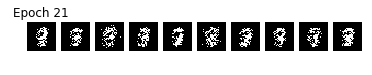

Epoch 22/100. Done: 22.00%. Latent Loss: 544.73. Decoder Loss: 22925.67. Loss: 23470.41. Took: 0:00:16.940064.
Epoch 22. Improvement from 23516.23 to 23470.41
Epoch 23/100. Done: 23.00%. Latent Loss: 525.34. Decoder Loss: 22928.45. Loss: 23453.77. Took: 0:00:15.971539.
Epoch 23. Improvement from 23470.41 to 23453.77
Epoch 24/100. Done: 24.00%. Latent Loss: 509.23. Decoder Loss: 22928.81. Loss: 23438.05. Took: 0:00:14.856733.
Epoch 24. Improvement from 23453.77 to 23438.05
Epoch 25/100. Done: 25.00%. Latent Loss: 495.24. Decoder Loss: 22919.15. Loss: 23414.38. Took: 0:00:14.965762.
Epoch 25. Improvement from 23438.05 to 23414.38
Epoch 26/100. Done: 26.00%. Latent Loss: 482.43. Decoder Loss: 22912.21. Loss: 23394.65. Took: 0:00:17.325227.
Epoch 26. Improvement from 23414.38 to 23394.65
Epoch 27/100. Done: 27.00%. Latent Loss: 471.18. Decoder Loss: 22904.96. Loss: 23376.14. Took: 0:00:18.836816.
Epoch 27. Improvement from 23394.65 to 23376.14
Epoch 28/100. Done: 28.00%. Latent Loss: 461.0

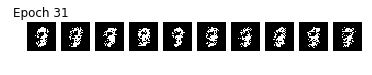

Epoch 32/100. Done: 32.00%. Latent Loss: 430.95. Decoder Loss: 22881.15. Loss: 23312.09. Took: 0:00:14.901968.
Epoch 33/100. Done: 33.00%. Latent Loss: 424.82. Decoder Loss: 22865.38. Loss: 23290.20. Took: 0:00:19.582254.
Epoch 33. Improvement from 23308.10 to 23290.20
Epoch 34/100. Done: 34.00%. Latent Loss: 419.68. Decoder Loss: 22859.10. Loss: 23278.78. Took: 0:00:16.842288.
Epoch 34. Improvement from 23290.20 to 23278.78
Epoch 35/100. Done: 35.00%. Latent Loss: 414.41. Decoder Loss: 22853.64. Loss: 23268.06. Took: 0:00:21.305465.
Epoch 35. Improvement from 23278.78 to 23268.06
Epoch 36/100. Done: 36.00%. Latent Loss: 409.66. Decoder Loss: 22832.22. Loss: 23241.89. Took: 0:00:24.224154.
Epoch 36. Improvement from 23268.06 to 23241.89
Epoch 37/100. Done: 37.00%. Latent Loss: 405.17. Decoder Loss: 22811.10. Loss: 23216.27. Took: 0:00:25.622037.
Epoch 37. Improvement from 23241.89 to 23216.27
Epoch 38/100. Done: 38.00%. Latent Loss: 404.98. Decoder Loss: 22750.94. Loss: 23155.93. Took:

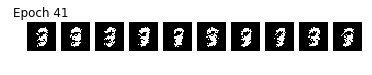

Epoch 42/100. Done: 42.00%. Latent Loss: 419.09. Decoder Loss: 22433.89. Loss: 22852.98. Took: 0:00:14.784648.
Epoch 42. Improvement from 22911.94 to 22852.98
Epoch 43/100. Done: 43.00%. Latent Loss: 425.01. Decoder Loss: 22459.66. Loss: 22884.66. Took: 0:00:14.769825.
Epoch 44/100. Done: 44.00%. Latent Loss: 419.62. Decoder Loss: 22330.33. Loss: 22749.96. Took: 0:00:14.783393.
Epoch 44. Improvement from 22852.98 to 22749.96
Epoch 45/100. Done: 45.00%. Latent Loss: 426.68. Decoder Loss: 22260.34. Loss: 22687.01. Took: 0:00:14.724439.
Epoch 45. Improvement from 22749.96 to 22687.01
Epoch 46/100. Done: 46.00%. Latent Loss: 439.14. Decoder Loss: 22184.25. Loss: 22623.38. Took: 0:00:14.720591.
Epoch 46. Improvement from 22687.01 to 22623.38
Epoch 47/100. Done: 47.00%. Latent Loss: 466.06. Decoder Loss: 22031.11. Loss: 22497.16. Took: 0:00:14.835115.
Epoch 47. Improvement from 22623.38 to 22497.16
Epoch 48/100. Done: 48.00%. Latent Loss: 540.84. Decoder Loss: 21710.79. Loss: 22251.63. Took:

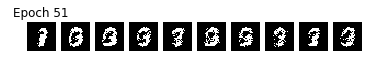

Epoch 52/100. Done: 52.00%. Latent Loss: 583.30. Decoder Loss: 21110.71. Loss: 21694.01. Took: 0:00:14.792237.
Epoch 52. Improvement from 21759.81 to 21694.01
Epoch 53/100. Done: 53.00%. Latent Loss: 576.50. Decoder Loss: 21051.78. Loss: 21628.28. Took: 0:00:14.685218.
Epoch 53. Improvement from 21694.01 to 21628.28
Epoch 54/100. Done: 54.00%. Latent Loss: 565.84. Decoder Loss: 21021.25. Loss: 21587.09. Took: 0:00:14.863300.
Epoch 54. Improvement from 21628.28 to 21587.09
Epoch 55/100. Done: 55.00%. Latent Loss: 557.26. Decoder Loss: 20981.19. Loss: 21538.46. Took: 0:00:14.808100.
Epoch 55. Improvement from 21587.09 to 21538.46
Epoch 56/100. Done: 56.00%. Latent Loss: 547.88. Decoder Loss: 20961.38. Loss: 21509.26. Took: 0:00:14.688210.
Epoch 56. Improvement from 21538.46 to 21509.26
Epoch 57/100. Done: 57.00%. Latent Loss: 540.53. Decoder Loss: 20929.56. Loss: 21470.10. Took: 0:00:14.659529.
Epoch 57. Improvement from 21509.26 to 21470.10
Epoch 58/100. Done: 58.00%. Latent Loss: 533.4

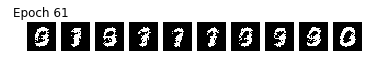

Epoch 62/100. Done: 62.00%. Latent Loss: 514.28. Decoder Loss: 20821.89. Loss: 21336.17. Took: 0:00:19.421993.
Epoch 62. Improvement from 21361.39 to 21336.17
Epoch 63/100. Done: 63.00%. Latent Loss: 510.58. Decoder Loss: 20801.79. Loss: 21312.37. Took: 0:00:18.464277.
Epoch 63. Improvement from 21336.17 to 21312.37
Epoch 64/100. Done: 64.00%. Latent Loss: 506.18. Decoder Loss: 20773.22. Loss: 21279.40. Took: 0:00:18.925713.
Epoch 64. Improvement from 21312.37 to 21279.40
Epoch 65/100. Done: 65.00%. Latent Loss: 503.24. Decoder Loss: 20762.53. Loss: 21265.78. Took: 0:00:22.247005.
Epoch 65. Improvement from 21279.40 to 21265.78
Epoch 66/100. Done: 66.00%. Latent Loss: 499.81. Decoder Loss: 20744.96. Loss: 21244.77. Took: 0:00:18.355427.
Epoch 66. Improvement from 21265.78 to 21244.77
Epoch 67/100. Done: 67.00%. Latent Loss: 497.61. Decoder Loss: 20727.14. Loss: 21224.75. Took: 0:00:14.869082.
Epoch 67. Improvement from 21244.77 to 21224.75
Epoch 68/100. Done: 68.00%. Latent Loss: 493.3

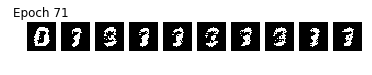

Epoch 72/100. Done: 72.00%. Latent Loss: 481.82. Decoder Loss: 20636.26. Loss: 21118.07. Took: 0:00:15.745108.
Epoch 72. Improvement from 21135.61 to 21118.07
Epoch 73/100. Done: 73.00%. Latent Loss: 480.32. Decoder Loss: 20622.97. Loss: 21103.29. Took: 0:00:15.829722.
Epoch 73. Improvement from 21118.07 to 21103.29
Epoch 74/100. Done: 74.00%. Latent Loss: 478.46. Decoder Loss: 20603.03. Loss: 21081.48. Took: 0:00:15.908686.
Epoch 74. Improvement from 21103.29 to 21081.48
Epoch 75/100. Done: 75.00%. Latent Loss: 476.72. Decoder Loss: 20585.48. Loss: 21062.21. Took: 0:00:17.583329.
Epoch 75. Improvement from 21081.48 to 21062.21
Epoch 76/100. Done: 76.00%. Latent Loss: 474.16. Decoder Loss: 20571.04. Loss: 21045.20. Took: 0:00:17.790193.
Epoch 76. Improvement from 21062.21 to 21045.20
Epoch 77/100. Done: 77.00%. Latent Loss: 472.25. Decoder Loss: 20548.25. Loss: 21020.50. Took: 0:00:25.384121.
Epoch 77. Improvement from 21045.20 to 21020.50
Epoch 78/100. Done: 78.00%. Latent Loss: 470.1

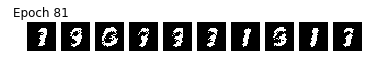

Epoch 82/100. Done: 82.00%. Latent Loss: 463.00. Decoder Loss: 20462.25. Loss: 20925.25. Took: 0:00:16.112922.
Epoch 82. Improvement from 20934.88 to 20925.25
Epoch 83/100. Done: 83.00%. Latent Loss: 461.91. Decoder Loss: 20435.43. Loss: 20897.34. Took: 0:00:24.302029.
Epoch 83. Improvement from 20925.25 to 20897.34
Epoch 84/100. Done: 84.00%. Latent Loss: 460.14. Decoder Loss: 20420.96. Loss: 20881.12. Took: 0:00:15.618299.
Epoch 84. Improvement from 20897.34 to 20881.12
Epoch 85/100. Done: 85.00%. Latent Loss: 458.59. Decoder Loss: 20403.89. Loss: 20862.48. Took: 0:00:16.092693.
Epoch 85. Improvement from 20881.12 to 20862.48
Epoch 86/100. Done: 86.00%. Latent Loss: 458.02. Decoder Loss: 20381.64. Loss: 20839.65. Took: 0:00:15.466827.
Epoch 86. Improvement from 20862.48 to 20839.65
Epoch 87/100. Done: 87.00%. Latent Loss: 455.11. Decoder Loss: 20364.23. Loss: 20819.35. Took: 0:00:14.856436.
Epoch 87. Improvement from 20839.65 to 20819.35
Epoch 88/100. Done: 88.00%. Latent Loss: 453.8

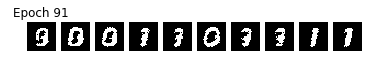

Epoch 92/100. Done: 92.00%. Latent Loss: 448.32. Decoder Loss: 20285.67. Loss: 20734.00. Took: 0:00:19.171285.
Epoch 92. Improvement from 20749.74 to 20734.00
Epoch 93/100. Done: 93.00%. Latent Loss: 445.86. Decoder Loss: 20276.20. Loss: 20722.06. Took: 0:00:19.081758.
Epoch 93. Improvement from 20734.00 to 20722.06
Epoch 94/100. Done: 94.00%. Latent Loss: 443.64. Decoder Loss: 20256.44. Loss: 20700.09. Took: 0:00:19.712140.
Epoch 94. Improvement from 20722.06 to 20700.09
Epoch 95/100. Done: 95.00%. Latent Loss: 440.17. Decoder Loss: 20241.45. Loss: 20681.62. Took: 0:00:19.510568.
Epoch 95. Improvement from 20700.09 to 20681.62
Epoch 96/100. Done: 96.00%. Latent Loss: 439.05. Decoder Loss: 20223.19. Loss: 20662.24. Took: 0:00:19.645491.
Epoch 96. Improvement from 20681.62 to 20662.24
Epoch 97/100. Done: 97.00%. Latent Loss: 437.35. Decoder Loss: 20213.69. Loss: 20651.04. Took: 0:00:19.280072.
Epoch 97. Improvement from 20662.24 to 20651.04
Epoch 98/100. Done: 98.00%. Latent Loss: 434.5

In [8]:
callbacks = [SaveModels("best"), PlotCallback()]
network.train_generator(generator, stepsPerEpoch=numIterations, numEpochs=100, callbacks=callbacks)


Finally, let's load the best model and generate some samples from it.

Succesfully loaded model (with history, epoch 101)


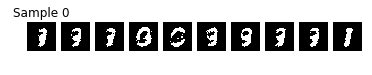

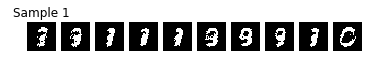

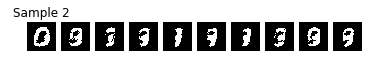

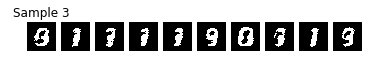

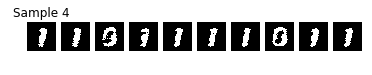

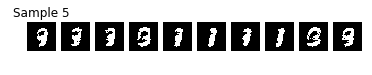

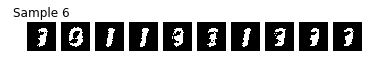

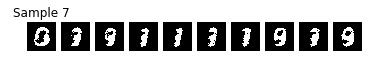

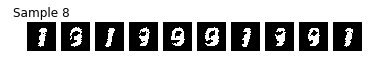

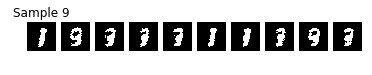

In [9]:
network.load_model("model_best.pkl")

for i in range(10):
    z_samples = Variable(maybeCuda(tr.randn(10, network.numEncodings)))
    y_result = network.decoder.forward(z_samples)
    result = maybeCpu(y_result.data).numpy().reshape((-1, 28, 28))
    result_binary = np.uint8(result > 0.5)
    title = "Sample %d" % (i)
    plot_images(result_binary, title)

Seems fairly biased on 1, 9 and 0s for this train, but overall looks good.

Nice.